# Análise do GRASP MCMC

## Inicialização

In [1]:
import os
import sys
import glob
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
#-----
import time
import subprocess
import emcee
from getdist import plots as gdplt
from getdist import MCSamples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], "src")))
import grasp
#-----
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)
InteractiveShell.ast_node_interactivity = "all"

## Emcee Analysis

In [2]:
def make_tor_mcmc(*thetas):
    dirname = "../grasp/STANDARD/tmp_mcmc/"
    # cria pasta
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    filename = dirname + str(np.random.randint(10000000)) + ".tor"
    feed_string1 = grasp.move_feed(y=thetas[0])
    # grava arquivo tor
    grasp._make_tor(filename, feed_string1, "../grasp/STANDARD/BINGO_CUT_fast.tor", 15, 7)
    sec_string = grasp.translate_secondary(y=thetas[1])
    grasp._make_tor(filename, sec_string, filename, 7, 0)
    return filename

In [3]:
df00 = grasp.read_cut("../grasp/STANDARD/tmp_mcmc/cut00.cut")
best_params = [0, 0]

def residual(df):
    FWHM = grasp.get_FWHM(df)
    gain_max = grasp.gain_max(df, FWHM)
    FWHM_0 = grasp.get_FWHM(df00)
    gain_0 = grasp.gain_max(df00, FWHM)
    result = - np.abs(gain_max - gain_0)/gain_0
    return result
    
    
def log_prior(thetas, t1_range=[-.2, .2], t2_range=[-.2, .2]):
    if (thetas[0] < 0.2) and (thetas[0] > -0.2):
        result = 0
    else:
        result = -np.inf
    return result


def log_likelyhood(thetas):
    tor_file = make_tor_mcmc(*thetas)
    _ = grasp.run_grasp(tor_file, 
                    gpxfile="../grasp/STANDARD/batch.gxp", 
                    tcifile="../grasp/STANDARD/BINGO_SIMPLES.tci", 
                    daemon=False)
    cut_file = ".." + tor_file.split(".")[-2] + ".cut"
    df = grasp.read_cut(cut_file)
    result = - residual(df)
    return result


def log_posterior(thetas):
    result = log_prior(thetas) + log_likelyhood(thetas)
    return result

In [9]:
ndim = len(best_params)
nburn = 1
nwalkers = 5
nsteps = 20
starting_guesses = np.random.normal(loc=0, scale=0.1, size=(nwalkers, ndim) )

In [10]:
import emcee

filename = "../grasp/STANDARD/tmp_mcmc/grasp_chains.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

#with Pool() as pool:
#    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, backend=backend)
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

/home/luciano/.conda/envs/grasp/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  5%|▌         | 1/20 [27:01<8:33:30, 1621.61s/it]/home/luciano/.conda/envs/grasp/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█         | 2/20 [54:04<8:06:39, 1622.20s/it]/home/luciano/.conda/envs/grasp/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 15%|█▌        | 3/20 [1:21:05<7:39:28, 1621.66s/it]/home/luciano/.conda/envs/grasp/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 20%|██        | 4/20 [1:48:14<7:13:12, 1624.51s/it]/home/luciano/.conda/envs/grasp/lib/pyth

In [11]:
reader = emcee.backends.HDFBackend(filename)

In [12]:
samples = reader.get_chain(flat=True)

Removed no burn in


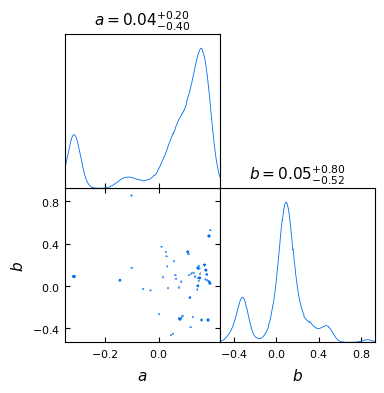

In [13]:
samples = MCSamples(samples=samples,names = ["a", "b"], labels = ["a", "b"])

g = gdplt.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot(samples, ['a', 'b'], 
    filled=True, 
    legend_loc='upper right', 
    title_limit=3
               )
plt.show();

In [14]:
samples